In [2]:
import os
from time import time, process_time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from utility import *
from LSTM import *

homedir = get_homedir()

TODAY = '0514'
date_ed = pd.Timestamp('2020-05-08')

PATH_PREP = f"{homedir}/JK/preprocessing/{TODAY}"
PATH = f"{homedir}/JK/prediction/{TODAY}"
split_ratio = 0.1
QUANTILE = list(quantileList)
history_size = 7
target_size = 14
step_size = 1
NUM_CELLS = 128
lr = 0.001
dp = 0.2
EPOCHS = 5

In [2]:
with open(PATH_PREP+f'/FIPS.txt', 'r') as f:
    FIPS_total = eval(f.read())

data_ctg = np.load(PATH_PREP+f'/data_ctg.npy', allow_pickle=True)
print(f'Categorical data of shape {data_ctg.shape} is loaded.')
data_ts = np.load(PATH_PREP+f'/data_ts.npy', allow_pickle=True)
print(f'Timeseries data of shape {data_ts.shape} is loaded.')

with open(PATH_PREP+f'/columns.txt', 'r') as f:
    columns = eval(f.read())
print(f'# of features = {len(columns)}')

target_idx = 1 #columns.index('deaths')

# try:
#     os.mkdir(PATH)
# except OSError as error:
#     print(error)

X_train, y_train, X_val, y_val, C_train, C_val = train_val_split(data_ts, data_ctg, target_idx, history_size, target_size, split_ratio=split_ratio, step_size=step_size)

scaler_ts, scaler_ctg = get_StandardScaler(X_train, C_train)

X_train, y_train = normalizer(scaler_ts, X_train, y_train, target_idx)
X_val, y_val = normalizer(scaler_ts, X_val, y_val, target_idx)
C_train, C_val = normalizer(scaler_ctg, C_train), normalizer(scaler_ctg, C_val)

train_data, val_data = load_Dataset(X_train, C_train, y_train, X_val, C_val, y_val)

lr_finder = LSTM_finder(train_data, val_data, lr=lr, NUM_CELLS=NUM_CELLS, EPOCHS=EPOCHS, dp=dp)
# model_qntl, history_qntl = LSTM_fit(train_data, val_data, lr=lr, NUM_CELLS=NUM_CELLS, EPOCHS=EPOCHS, dp=dp, monitor=True)

# for i in range(len(QUANTILE)):
#     FILEPATH = f"/LSTM_class={c}_qntl={10*(i+1)}"
#     plot_train_history(history_qntl[i], title=f'History size={history_size}, dropout={dp}', path=PATH+FILEPATH+'.png')
#     # np.save(PATH+FILEPATH+'.npy', np.vstack((LOSS, VAL_LOSS)).astype(np.float32))

# df_future = predict_future(model_qntl, dataList[c], scaler, target_idx, FIPS=FIPS_cluster[c], date_ed=date_ed)
# df_future.to_csv(PATH+f'/LSTM_class={c}_{TODAY}.csv', index=False)

Categorical data of shape (3114, 41) is loaded.
Timeseries data of shape (3114, 69, 5) is loaded.
# of features = 46
Quantile=10 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 84/200 [===========>..................] - ETA: 1s - loss: 0.0830Quantile=20 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 46/200 [=====>........................] - ETA: 3s - loss: 0.1241Quantile=30 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 47/200 [======>.......................] - ETA: 3s - loss: 0.1289Quantile=40 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 72/200 [=========>....................] - ETA: 2s - loss: 0.1473Quantile=50 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 37/200 [====>.........................] - ETA: 5s - loss: 0.1533Quantile=60 is trained
Train for 200 steps, validate for 50 steps
Epoch 1/5
 12/200 [>.............................] - ETA: 14s - loss: 0.2051Quantile=70 is trained
Train for 200

In [3]:
X_train, y_train, X_val, y_val, X_ctg = train_val_split(data_ts, data_ctg, target_idx, history_size, target_size, split_ratio=split_ratio, step_size=step_size)
print(X_train.shape, X_ctg.shape)

(118332, 7, 5) (118332, 41)


In [3]:
_ = list(train_data.cache().shuffle(10000).batch(2).as_numpy_iterator())[0]

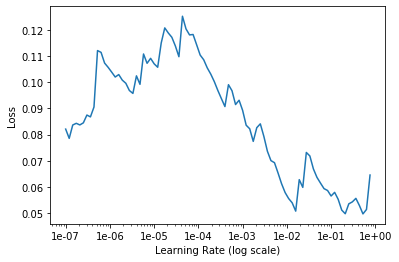

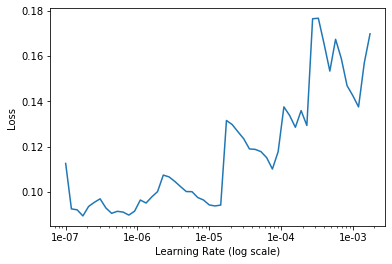

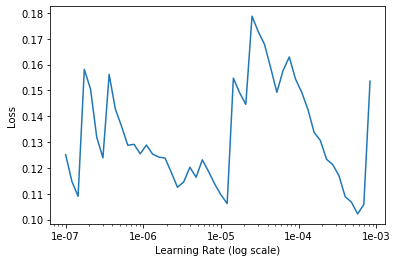

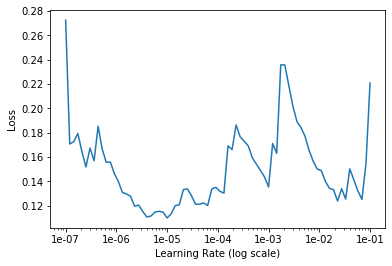

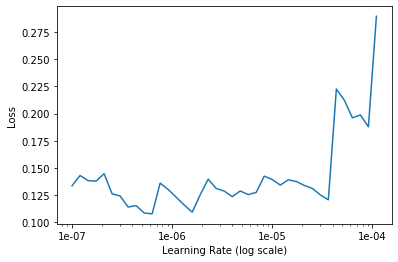

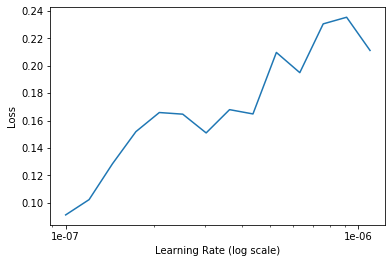

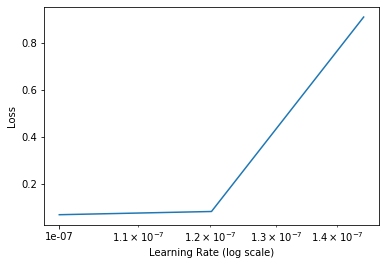

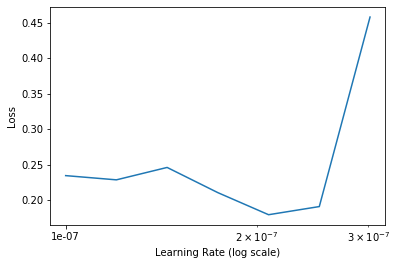

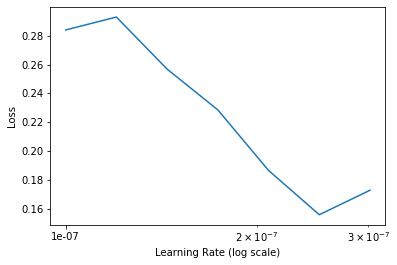

In [3]:
for i in range(9):
    lr_finder[i].plot()

In [4]:
scaler_ts, scaler_ctg = get_StandardScaler(X_train, X_ctg)

In [3]:
train_data, val_data = load_Dataset(X_train, C_train, y_train, X_val, C_val, y_val)

In [13]:
train_data.cache().shuffle(10000).batch(2).element_spec[1].shape[1]

14

In [11]:
_ = (1, (3, "apple"))
for i, j in enumerate(_):
    print(i,j)

0 1
1 (3, 'apple')


In [7]:
a = tf.data.Dataset.range(1, 4)
b = tf.data.Dataset.range(4, 7)
ds = tf.data.Dataset.zip((a, b))
list(ds.as_numpy_iterator())

[(1, 4), (2, 5), (3, 6)]

In [9]:
target_size = 14
NUM_CELLS = 128
model_test = SingleLayerConditionalRNN(NUM_CELLS, target_size, 0.2, quantileList)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model_test.compile(optimizer=optimizer, loss=lambda y_p, y: MultiQuantileLoss(quantileList, target_size, y_p, y))
load_status = model_test.load_weights(f"{homedir}/JK/prediction/0526_test/LSTM_mult_hist_size_7_weights")
load_status.assert_consumed()

AssertionError: Unresolved object in checkpoint (root).layer1.init_state: 

In [10]:
df_future = predict_future_mult(model_test, data_ts, data_ctg, scaler_ts, scaler_ctg, history_size, target_idx, FIPS=FIPS_total, date_ed=date_ed-pd.Timedelta(days=timedelta))
    df_future.to_csv(PATH+f'/LSTM_mult_hist_size_{history_size}_{TODAY}_{i}.csv', index=False)

[]